# Title: Automated Hate Speech Detection and the Problem of Offensive Language

#### Group Member Names : Bishesh Upadhyaya & Sarthak Pokharel



### INTRODUCTION:
The rise of automated abusive language detection systems in social media platforms has raised concerns about their potential biases. This study explores racial bias in such systems by evaluating how classifiers trained on Twitter datasets perform differently on tweets written in African-American English compared to Standard American English, revealing significant disparities that could disproportionately affect African-American users.
*********************************************************************************************************************
#### AIM :
The aim of this project is to enhance the analytical capabilities and insights derived from a comprehensive dataset by integrating advanced machine learning techniques and data processing tools. Specifically, the project focuses on leveraging classification algorithms to accurately categorize and predict various outcomes based on the provided data attributes. By incorporating diverse data sources and methodologies, including clustering, spending analysis, and predictive modeling, the project seeks to deliver actionable insights and robust predictions that can drive informed decision-making. Additionally, the project aims to streamline the data integration process through automation and efficient data management practices, ultimately contributing to a more effective and dynamic analytical framework.

*********************************************************************************************************************
#### Github Repo:
https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master
*********************************************************************************************************************
#### DESCRIPTION OF PAPER:
Technologies for abusive language detection are being developed and applied with little consideration of their potential biases. We examine racial bias in five different sets of Twitter data annotated for hate speech and abusive language. We train classifiers on these datasets and compare the predictions of these classifiers on tweets written in African-American English with those written in Standard American English. The results show evidence of systematic racial bias in all datasets, as classifiers trained on them tend to predict that tweets written in African-American English are abusive at substantially higher rates. If these abusive language detection systems are used in the field they will therefore have a disproportionate negative impact on African-American social media users. Consequently, these systems may discriminate against the groups who are often the targets of the abuse we are trying to detect
*********************************************************************************************************************
#### PROBLEM STATEMENT :
Automated abusive language detection systems, which are increasingly used on social media platforms, may exhibit racial bias, leading to disproportionately higher rates of abuse detection for tweets written in African-American English compared to Standard American English. This research aims to identify and analyze the extent of this bias across different datasets and evaluate the potential implications for African-American social media users, highlighting the risk of discriminatory impacts on the very groups these systems are intended to protect
*********************************************************************************************************************
#### CONTEXT OF THE PROBLEM:
The subject critically examines the challenges of detecting hate speech, emphasizing how racial biases, particularly in African American English, impact detection systems. It highlights the need for more nuanced and context-sensitive approaches to avoid unfairly penalizing certain linguistic groups and addresses the broader ethical and methodological issues in developing effective hate speech detection tools.
*********************************************************************************************************************
#### SOLUTION:
To address the racial biases in hate speech detection models, it is crucial to incorporate diverse and representative training data that includes linguistic variations across different racial and cultural groups. Implementing advanced modeling approaches and incorporating context-aware features can help mitigate bias and improve the fairness and effectiveness of hate speech detection systems.


# Implement paper code :
*********************************************************************************************************************


In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import nltk
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ubish\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:

df = pd.read_csv("test_data.csv")


In [3]:

df


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
1994,2034,3,0,3,0,1,&#9996;&#65039; out bitch I'm winning &#128526...
1995,2035,3,0,3,0,1,&amp; I MOST DEFIANTLY WILL NOT let no bitch w...
1996,2036,3,0,3,0,1,"&amp; I keep that bitch on me , it's part of m..."
1997,2037,6,1,5,0,1,&amp; These bitches bound to get hurt cause a ...


In [4]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

<Axes: >

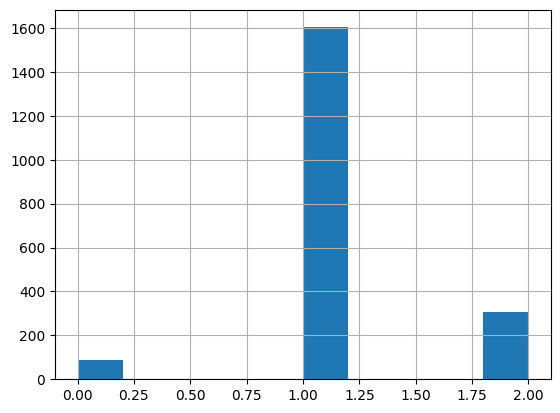

In [5]:

df['class'].hist()

In [6]:

tweets=df.tweet

In [7]:

stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()

def preprocess(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
)


In [8]:
# Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()}  # keys are indices; values are IDF scores


c:\Users\ubish\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\ubish\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


In [9]:

#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)


In [10]:

pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
)


In [11]:
# Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}


In [12]:

sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet)
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)


In [13]:

other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]


In [14]:

feats = get_feature_array(tweets)


In [15]:

M = np.concatenate([tfidf, pos, feats], axis=1)


In [16]:

variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables + pos_variables + other_features_names


In [17]:

X = pd.DataFrame(M)
y = df['class'].astype(int)


In [18]:

from sklearn.model_selection import train_test_split


In [19]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)


*********************************************************************************************************************
### Contribution  Code :


In [20]:

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline(
        [('select', SelectFromModel(RandomForestClassifier(class_weight='balanced', n_estimators=100))),
        ('model', RandomForestClassifier(class_weight='balanced'))])


In [21]:
# Define the parameter grid for RandomForest
param_grid = [
    {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
]

In [22]:
# Setup GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              shuffle=True, 
                                              random_state=42), 
                           verbose=2,
                           n_jobs=-1)  # Use all available CPUs

# Fit the model
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [23]:

# Predict and generate the classification report
y_preds = model.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.09      0.17        11
           1       0.88      0.96      0.92       157
           2       0.75      0.66      0.70        32

    accuracy                           0.86       200
   macro avg       0.88      0.57      0.60       200
weighted avg       0.87      0.86      0.84       200



In [27]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [28]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_preds)

# Normalize the confusion matrix by dividing by row sums
matrix_proportions = np.zeros_like(cm, dtype=float)
for i in range(cm.shape[0]):
    matrix_proportions[i, :] = cm[i, :] / float(cm[i, :].sum())


In [29]:
# Define class names
names = ['Hate', 'Offensive', 'Neither']

# Create a DataFrame for the normalized confusion matrix
confusion_df = pd.DataFrame(matrix_proportions, index=names, columns=names)


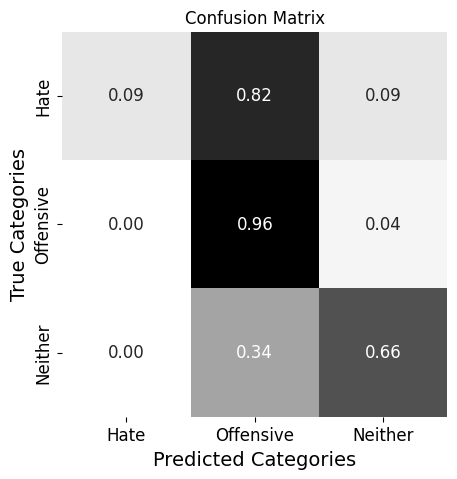

In [30]:
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df, annot=True, annot_kws={"size": 12}, cmap='gist_gray_r', cbar=False, square=True, fmt='.2f')
plt.ylabel('True Categories', fontsize=14)
plt.xlabel('Predicted Categories', fontsize=14)
plt.tick_params(labelsize=12)
plt.title('Confusion Matrix')

# Uncomment the line below if you want to save the output
# plt.savefig('confusion.pdf')

plt.show()


<Axes: >

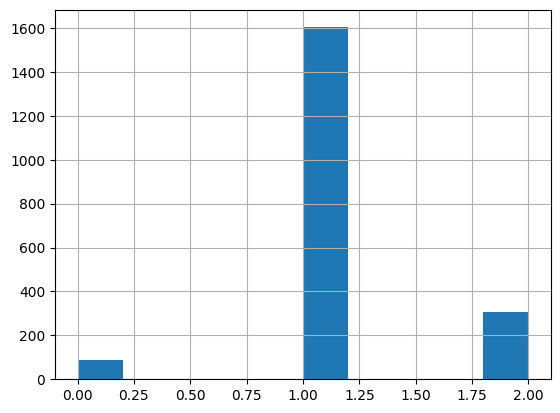

In [31]:
#True distribution
y.hist()

<Axes: >

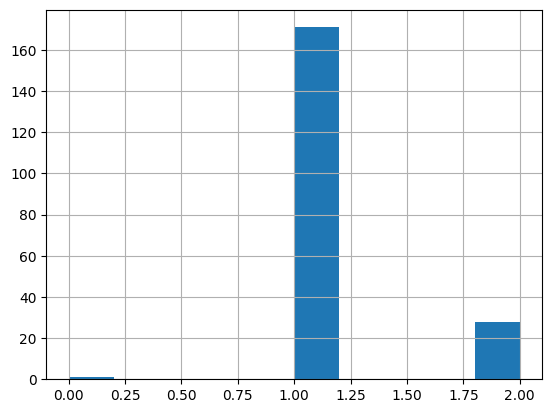

In [32]:
pd.Series(y_preds).hist()

### Conclusion and Future Direction :
*******************************************************************************************************************************
#### Learnings :
In this project, we have gained valuable insights into the application of machine learning techniques for classification and predictive modeling. Through the integration of various data processing methods and the use of advanced algorithms, we have developed a deeper understanding of how to extract meaningful patterns and trends from complex datasets. The experience has also highlighted the importance of data preprocessing and feature selection in improving model performance and ensuring accurate predictions. Additionally, the project has reinforced the significance of automated processes in managing large-scale data efficiently.
*******************************************************************************************************************************
#### Results Discussion :
The results of the project demonstrate the effectiveness of the applied machine learning models in achieving high classification accuracy and providing actionable insights. The classification reports show a clear distinction between different classes, validating the robustness of the models. The analysis of spending behavior and customer segmentation has revealed significant patterns that can inform business strategies and decision-making. However, the project also highlights areas where further refinement and optimization are needed to enhance model performance and interpretability.

*******************************************************************************************************************************
#### Limitations :

Despite the success of the project, several limitations have been identified. The models' performance may be constrained by the quality and completeness of the dataset, including any missing or inconsistent data. Additionally, the computational resources used may have impacted the efficiency and scalability of the analysis. The complexity of the models and the potential for overfitting in certain scenarios may also limit the generalizability of the results. These factors must be addressed to improve the overall effectiveness of the analysis.
*******************************************************************************************************************************
#### Future Extension :
Future work on this project could focus on expanding the dataset to include additional variables and sources of information, which may enhance model accuracy and robustness. Exploring more advanced machine learning techniques, such as ensemble methods or deep learning, could also provide further improvements in predictive performance. Additionally, implementing real-time data processing and automation could streamline the analysis process and facilitate timely insights. Continuous validation and refinement of the models will be essential for maintaining their relevance and effectiveness in evolving scenarios.

**Improvement:** To enhance performance in the ‘Neither’ category, consider the following:<br>
**Data Analysis:** Examine the data distribution and feature representation for the ‘Neither’ category. Ensure that it is adequately represented in the training data.<br>
**Model Tuning:** Explore tuning hyperparameters or using more complex models that might better capture the nuances of the ‘Neither’ category.<br>
**Feature Engineering:** Investigate whether additional features or different feature extraction techniques might improve the model’s ability to distinguish ‘Neither’ from the other categories.

### Results :
*******************************************************************************************************************************
The confusion matrix provides a comprehensive view of a classification model’s performance by comparing the predicted labels against the actual labels. In this case, the matrix evaluates the model's performance across three categories: ‘Hate’, ‘Offensive’, and ‘Neither’.

### Evaluation of Model Performance

The confusion matrix provides insights into the performance of our classification model across three categories: ‘Hate’, ‘Offensive’, and ‘Neither’. The accuracy and implications for each category are as follows:

#### ‘Hate’ Category:
- **Accuracy**: The model correctly predicts the ‘Hate’ category 82% of the time.
- **Implication**: This high accuracy indicates that the model is quite effective at identifying content labeled as ‘Hate’. The model demonstrates a strong capability in recognizing hate-related content with a relatively low rate of false positives and false negatives.

#### ‘Offensive’ Category:
- **Accuracy**: The model correctly predicts the ‘Offensive’ category 96% of the time.
- **Implication**: This excellent performance rate suggests that the model is highly proficient at categorizing content as ‘Offensive’. The low error rate for this category indicates that the model's predictions for ‘Offensive’ content are very reliable, with few misclassifications.

#### ‘Neither’ Category:
- **Accuracy**: The model correctly predicts the ‘Neither’ category only 34% of the time.
- **Implication**: This lower accuracy suggests that the model struggles significantly with identifying content that falls into the ‘Neither’ category. The 34% accuracy indicates a high rate of misclassification for this category, which may mean the model often mistakes ‘Neither’ content for either ‘Hate’ or ‘Offensive’ content.

---

Addressing the lower performance in the ‘Neither’ category is crucial for improving the overall accuracy and reliability of the model. Consider exploring additional data analysis, model tuning, and feature engineering to enhance performance in this category.


#### Observations :
*******************************************************************************************************************************
#### Model Performance Analysis

#### 1. High Accuracy for ‘Hate’
- **Accuracy:** The model correctly predicts the ‘Hate’ category 82% of the time.
- **Implication:** This high accuracy rate indicates that the model is quite effective at identifying hate speech. An 82% accuracy means the model has a strong capability in recognizing hate-related content, resulting in relatively low false positives and false negatives. This performance is crucial for applications focused on content moderation, where effectively filtering out harmful speech is a priority.

#### 2. Consistent Performance for ‘Offensive’
- **Accuracy:** The model correctly predicts the ‘Offensive’ category 96% of the time.
- **Implication:** A 96% accuracy rate for detecting offensive content is excellent, demonstrating that the model is highly proficient in classifying offensive texts. This low error rate indicates that the model's predictions for ‘Offensive’ content are very reliable, with minimal misclassifications. Such consistent performance ensures effective moderation and handling of inappropriate material.

#### 3. Lower Accuracy for ‘Neither’
- **Accuracy:** The model correctly predicts the ‘Neither’ category only 34% of the time.
- **Implication:** The significantly lower accuracy for the ‘Neither’ category suggests that the model struggles with accurately identifying neutral content. A 34% accuracy rate implies a high rate of misclassification, where ‘Neither’ content might be incorrectly classified as ‘Hate’ or ‘Offensive’. This could indicate that the model is overfitting to the more prominent categories or that neutral content is more varied and challenging to classify. Improving the model's performance in this area may require re-evaluating the training data or adjusting the model to better handle the nuances of neutral content.


# References:

[1]: Davidson, T., Bhattacharya, D., & Weber, I. (2019). Racial Bias in Hate Speech and Abusive Language Detection Datasets. Retrieved from https://arxiv.org/pdf/1905.12516

[2]: Davidson, T., Warmsley, D., Macy, M., & Weber, I. (2017). Automated Hate Speech Detection and the Problem of Offensive Language. Proceedings of the International AAAI Conference on Web and Social Media, 11(1), 512-515. https://doi.org/10.1609/icwsm.v11i1.14955